## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Ковалишин Никита Игоревич

Группа: ML-22

In [ ]:
import numpy as np
from google.colab import output
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 14 ноября.


# Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [ ]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
images_train, labels_train = next(iter(train_loader))

In [ ]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

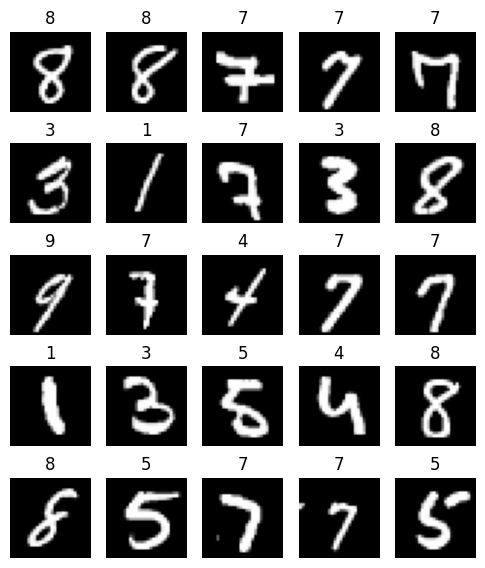

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [ ]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

def NetworkInitializer(linLayersCount, activation, layersSizes, initType = 'STD'):
    VALID_INIT_TYPES = ['STD', 'XAVIER', 'HE']
    if not(len(layersSizes) == (linLayersCount + 1)):
        return -1
    if initType not in VALID_INIT_TYPES:
        return -2
    network = nn.Sequential()
    for i in range(linLayersCount):
        linLayer = nn.Linear(layersSizes[i], layersSizes[i+1])
        linLayer.register_forward_hook(forward_hook)
        linLayer.register_backward_hook(backward_hook)
        if initType == 'STD':
            init_layer(linLayer)
        if initType == 'XAVIER':
            init_layer(linLayer, std = 2 / (layersSizes[i] + layersSizes[i+1]))
        if initType == 'HE':
            init_layer(linLayer, std = 2 / (layersSizes[i]))
        network.append(linLayer)
        network.append(activation)
    return network

## Задание 1. Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

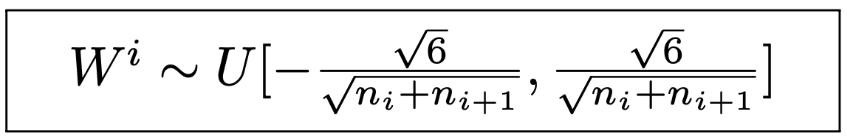

### На вход передаем изображение 28x28, на выходе -- вероятности 10 классов:

In [ ]:
networkTanh_STDInit = NetworkInitializer(4, nn.Tanh(), [28*28, 500, 100, 100, 10])
networkTanh_XavierInit = NetworkInitializer(4, nn.Tanh(), [28*28, 500, 100, 100, 10], initType = 'XAVIER')
networkReLU_STDInit = NetworkInitializer(4, nn.ReLU(), [28*28, 500, 100, 100, 10])
networkReLU_HeInit = NetworkInitializer(4, nn.ReLU(), [28*28, 500, 100, 100, 10], initType = 'HE')

### Дисперсии input-forward и input-backward значений при обычной инициализации нейросети с активацией nn.Tanh():

In [ ]:
print("Standard params init in network with nn.Tanh():\n")
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = networkTanh_STDInit(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(networkTanh_STDInit.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

Standard params init in network with nn.Tanh():

forward 1.0022183656692505
forward 0.9848760962486267
forward 0.9822328090667725
forward 0.9602869153022766
backward 0.005925029516220093
backward 0.005655810236930847
backward 0.007234892342239618
backward 0.010113921016454697


### Дисперсии input-forward и input-backward значений при Xavier-инициализации нейросети с активацией nn.Tanh():

In [ ]:
print("Xavier params init in network with nn.Tanh():\n")
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = networkTanh_XavierInit(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(networkTanh_XavierInit.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

Xavier params init in network with nn.Tanh():

forward 1.0022183656692505
forward 0.04382447898387909
forward 0.003173551755025983
forward 0.0003362235438544303
backward 0.0336650125682354
backward 0.006204151548445225
backward 0.0006437789998017251
backward 2.1077237761346623e-05


### Дисперсии input-forward и input-backward значений при обычной инициализации нейросети с активацией nn.ReLU():

In [ ]:
print("Standard params init in network with nn.ReLU():\n")
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = networkReLU_STDInit(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(networkReLU_STDInit.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

Standard params init in network with nn.ReLU():

forward 1.0022183656692505
forward 16.245450973510742
forward 262.0146484375
forward 2061.207275390625
backward 0.05033222585916519
backward 0.1335850954055786
backward 0.8378642201423645
backward 5.182329177856445


### Дисперсии input-forward и input-backward значений при He-инициализации нейросети с активацией nn.ReLU():

In [ ]:
print("He params init in network with nn.ReLU():\n")
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = networkReLU_HeInit(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(networkReLU_HeInit.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

He params init in network with nn.ReLU():

forward 1.0022183656692505
forward 0.04076036438345909
forward 0.0027413368225097656
forward 0.00036204056232236326
backward 0.048819392919540405
backward 0.0031203930266201496
backward 0.00039834980270825326
backward 9.448265700484626e-06


В случае с инициализацией Xavier видно, что стандартные отклонения по мере прохождения forward и backward стали уменьшаться и стремиться к 0. Это хорошо, так как производная Tanh() в окрестности нуля равна 1. Получается, что входные значения при инициализации лежат в области ненасыщенности Tanh().

Так же есть согласованность forward_inputs и backward_inputs. Это очень хорошо, так как по мере прохождения по слоям во время обучения, веса будут по всем слоям изменяться одинаково, что поможет нам избежать проблемы затухающего градиента.

He-инициализация нейросети с ReLU() активацией аналогично помогла достичь наилучшей согласованности и уменьшить дисперсию входных значений. Но в нейросетях с активацией ReLU дисперсию входных значений уменьшать нужно для того, чтобы наоборот не было взрывающегося градиента. Так же He-инициализация помогает решить проблему мёртвых нейронов, которые уже не способны обучаться.

Таким образом, Xavier инициализация должна помочь комплексно решить проблему затухающего градиента как за счёт уменьшения дисперсий входных значений, так и за счёт их согласованности.

# Часть 2: DropConnect

## Задание 2. Реализуйте DropConnect по следующему шаблону: **(1 балл)**

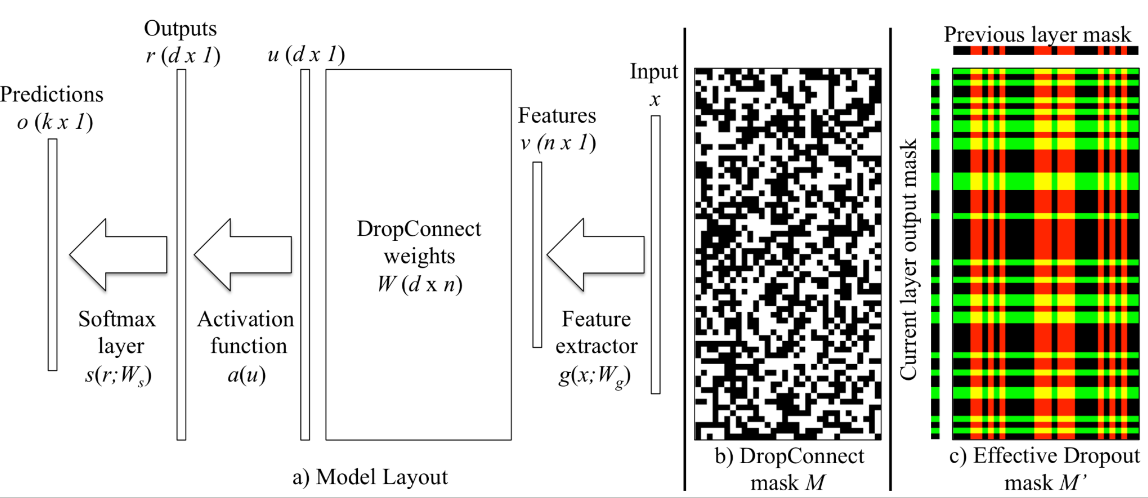

### Реализация DropConnect:

In [ ]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.zeros_like(self.linear.weight, requires_grad=False)
        mask.bernoulli_(p = 1 - self.p)
        if not(self.training):
            mask = torch.where(mask > self.p, 1, 1 - self.p)
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

### Реализация DropOut (для сравнения):

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)
        return x * mask


## Задание 3. Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


### Основа для сети, которую будем обучать:

In [ ]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()
        channels = 1
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        self.final_part = final_part
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

### Добавим несколько слоев в конец сети:

In [ ]:
layersSTD = [#standard layers
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]
layersDC = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]
layersDO = [
    Dropout(),
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

### Инициализация моделей, оптимизаторов и Loss функций (стандартной, c drop connections и drop out):

In [ ]:
networkSTD = TestNetwork(nn.Sequential(*layersSTD))
optimizerSTD = torch.optim.Adam(networkSTD.parameters(), lr=0.001)
criterionSTD = torch.nn.NLLLoss()
networkDC = TestNetwork(nn.Sequential(*layersDC))
optimizerDC = torch.optim.Adam(networkDC.parameters(), lr=0.001)
criterionDC = torch.nn.NLLLoss()
networkDO = TestNetwork(nn.Sequential(*layersDO))
optimizerDO = torch.optim.Adam(networkDO.parameters(), lr=0.001)
criterionDO = torch.nn.NLLLoss()

### Функция для обучения моделей:

In [ ]:
def train(network, optimizer, criterion):
    trainLossLst = []
    valLossLst = []
    for epoch in range(20):
        network.train()
        trainLossLst += [0]
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = criterion(output, y)
            trainLossLst[epoch] += loss.item()
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        trainLossLst[epoch] /= len(train_loader)
        network.eval()
        valLossLst += [0]
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = criterion(output, y)
            valLossLst[epoch] += loss.item()
        valLossLst[epoch] /= len(test_loader)
    return trainLossLst, valLossLst

### Обучение моделей:

In [ ]:
trainLossLstSTD, valLossLstSTD = train(networkSTD, optimizerSTD, criterionSTD)
output.clear()

In [ ]:
trainLossLstDC, valLossLstDC = train(networkDC, optimizerDC, criterionDC)
output.clear()

In [ ]:
trainLossLstDO, valLossLstDO = train(networkDO, optimizerDO, criterionDO)
output.clear()

### Сравнение Drop Connection, Drop Out с нативным обучением

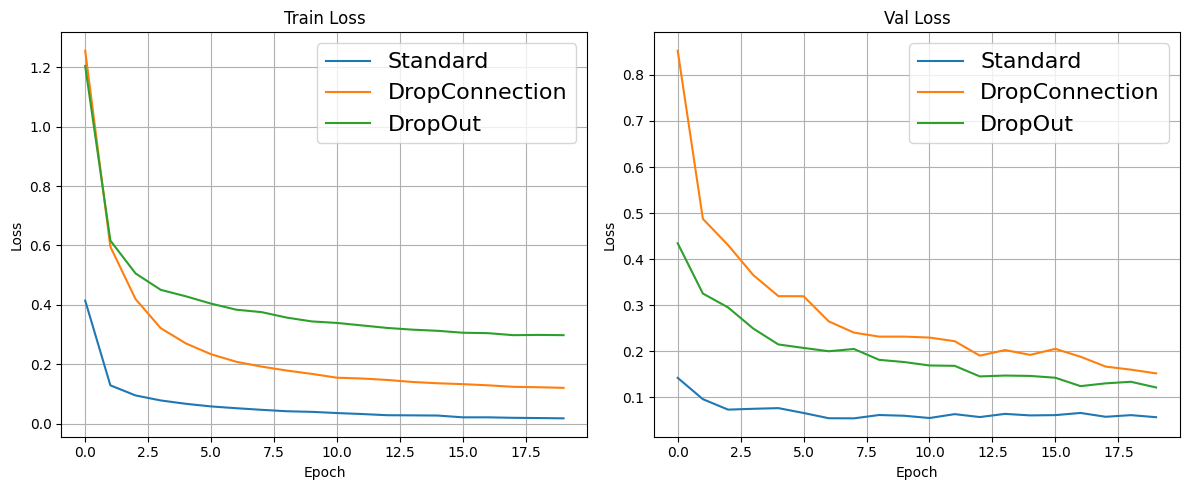

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLossLstSTD, label='Standard')
plt.plot(trainLossLstDC, label='DropConnection')
plt.plot(trainLossLstDO, label='DropOut')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0, fontsize=16)
plt.tight_layout()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(valLossLstSTD, label='Standard')
plt.plot(valLossLstDC, label='DropConnection')
plt.plot(valLossLstDO, label='DropOut')
plt.title('Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0, fontsize=16)
plt.tight_layout()
plt.grid()

plt.show()

### Выводы по сравнению DropConnection и DropOut:

DropConnection показал себя по скорости обучения на train'e лучше, чем DropOut, но на валидации DropOut проявил себя лучше, чем DropConnection. Я думаю, что из-за того, что DropOut просто убирает признаки, и вместе с этим убирает немного большую часть информации именно для обучения, чем DropConnect, поэтому нейронной сети тяжелее обучаться.

Но в то же время обобщаемость обучения страдает больше именно в DropConnection, потому что весам в совокупности тяжелее подстроиться под какую-то общую закономерность, когда у них рандомная разреженность, нежели когда просто убираются какие-то признаки. Это и видно на валидации.

В целом, если подытожить, результаты ожидаемые. Drop Connection по сути является обобщением Drop Out, и по мере обучения он обучает более разнообразные модели, которые могут быстро находить какие-то мелкие закономерности train'a, но общие находить он будет скорее всего дольше.

# Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

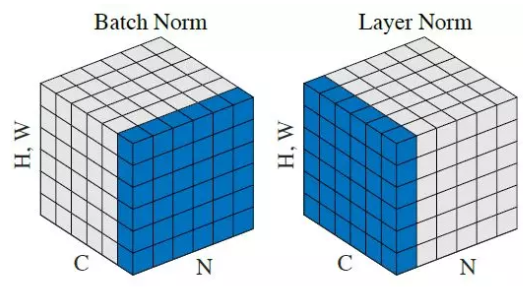

### Реализация Batch Normalization:

In [ ]:
class MyBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        super(MyBatchNorm, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features, requires_grad=False)
        self.running_var = torch.zeros(num_features, requires_grad=False)

    def forward(self, input):
        if self.training:
            if len(input.shape) > 2:
                mean = input.permute(1, 0, -1).flatten(start_dim=1).mean(dim=1)
                var = input.permute(1, 0, -1).flatten(start_dim=1).var(dim=1)
            else:
                mean = input.permute(1, 0).mean(dim=1)
                var = input.permute(1, 0).var(dim=1)
            with torch.no_grad():
                self.running_mean = self.running_mean * self.momentum + mean * (1 - self.momentum)
                self.running_var = self.running_var * self.momentum + var * (1 - self.momentum)
        else:
            mean = self.running_mean
            var = self.running_var
        mean = mean.unsqueeze(dim=0)
        var = var.unsqueeze(dim=0)
        for i in range(len(input.shape) - len(mean.shape)):
            mean = mean.unsqueeze(dim=len(mean.shape))
        for i in range(len(input.shape) - len(var.shape)):
            var = var.unsqueeze(dim=len(var.shape))
        input = (input - mean) / (torch.sqrt(var + self.eps))
        return input

## Задание 4. Реализуйте Layer Normalization **(1 балл)**

In [ ]:
# полезные функции: .std(dim), .mean(dim)

#я читал, что для Layer Normalization не обязательно накапливать скользящее среднее,
#так как на тесте мы гарантируем, что спокойно сможем посчитать mean и var
class LayerNormalization(nn.Module):

    def __init__(self, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps

    def forward(self, x):
        mean = x.view(x.size(0), -1).mean(dim=1)
        var = x.view(x.size(0), -1).var(dim=1)
        for i in range(len(x.shape) - len(mean.shape)):
            mean.unsqueeze_(dim=len(mean.shape))
        for i in range(len(x.shape) - len(var.shape)):
            var.unsqueeze_(dim=len(var.shape))
        output = (x - mean) / (torch.sqrt(var + self.eps))
        return output

## Задание 5. Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

### Инициализация слоёв:

In [ ]:
layersBN = [
    MyBatchNorm(196),
    nn.Linear(196, 128),
    nn.ReLU(),
    MyBatchNorm(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    MyBatchNorm(128),
    nn.Linear(128, 10)
]
layersLN = [
    LayerNormalization(),
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 10)
]

### Инициализация моделей (с Batch Norm и Layer Norm добавками):

In [ ]:
networkBN = TestNetwork(nn.Sequential(*layersBN))
optimizerBN = torch.optim.Adam(networkBN.parameters(), lr=0.001)
criterionBN = torch.nn.NLLLoss()
networkLN = TestNetwork(nn.Sequential(*layersLN))
optimizerLN = torch.optim.Adam(networkLN.parameters(), lr=0.001)
criterionLN = torch.nn.NLLLoss()

### Обучение моделей:

In [ ]:
trainLossLstBN, valLossLstBN = train(networkBN, optimizerBN, criterionBN)
output.clear()

In [ ]:
trainLossLstLN, valLossLstLN = train(networkLN, optimizerLN, criterionLN)
output.clear()

### Графическое сравнение Batch Norm, Layer Norm с нативным обучением:

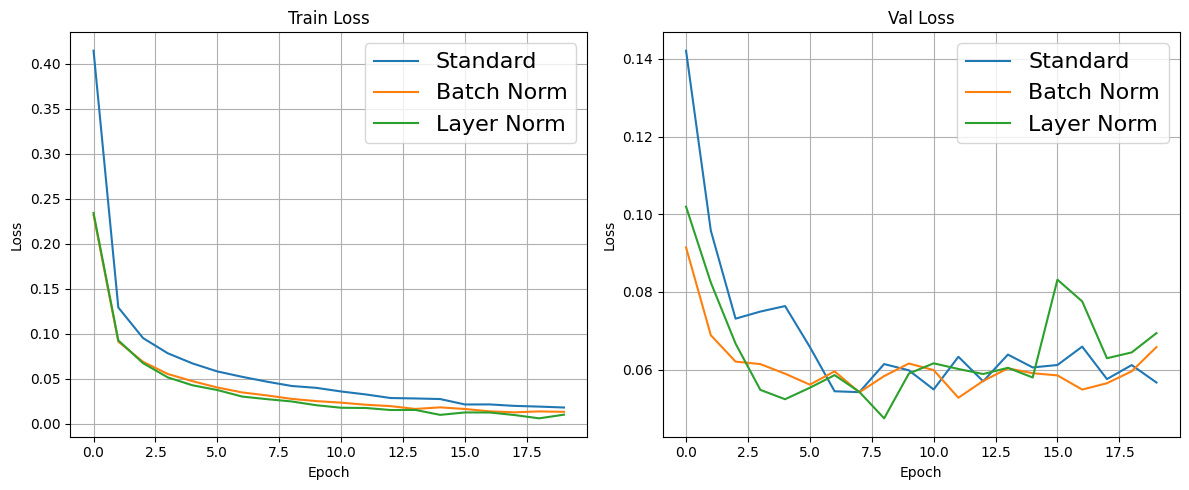

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLossLstSTD, label='Standard')
plt.plot(trainLossLstBN, label='Batch Norm')
plt.plot(trainLossLstLN, label='Layer Norm')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0, fontsize=16)
plt.tight_layout()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(valLossLstSTD, label='Standard')
plt.plot(valLossLstBN, label='Batch Norm')
plt.plot(valLossLstLN, label='Layer Norm')
plt.title('Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0, fontsize=16)
plt.tight_layout()
plt.grid()

plt.show()

Выводы по Batch Norm и Layer Norm.

В целом они показывают себя одинаково в том плане, что ускоряют сходимость. Но стоит отметить, что Linear Norm показал получше результат в плане скорости сходимости на Train'e, нежели Batch Norm. Даже настолько лучше, что на валидации начались скачки, что свидетельствует о начале переобучения. То есть можно было бы с Linear Norm остановиться пораньше, итерации на 12-13.

Но преимущество Layer Norm не только в этом. Так же у него нет зависимости от размера батча, и не нужно накапливать моментумы mean и var для теста. То есть он более универсальный.